<a href="https://colab.research.google.com/github/zunderlab/eschr/blob/main/docs/notebooks/paul15_mouse_hematopoiesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESCHR analysis of mouse hematopoiesis

Finding population strucutures in scRNAseq of myeloid and erythroid differentiation from [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

## Setup environment

In [1]:
!pip install git+https://github.com/zunderlab/eschr.git

  Cloning https://github.com/zunderlab/eschr.git (to revision zarr_anndata) to /tmp/pip-req-build-wez41lh5
  Running command git clone --filter=blob:none --quiet https://github.com/zunderlab/eschr.git /tmp/pip-req-build-wez41lh5
  Running command git checkout -b zarr_anndata --track origin/zarr_anndata
  Switched to a new branch 'zarr_anndata'
  Branch 'zarr_anndata' set up to track remote branch 'zarr_anndata' from 'origin'.
  Resolved https://github.com/zunderlab/eschr.git to commit 8ec212f9eae2367e4e07294378a99759d608dc93
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0

In [2]:
import eschr as es

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc

In [4]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

## Read in and preprocess data

In [5]:
adata = sc.datasets.paul15()
adata

  0%|          | 0.00/9.82M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [6]:
sc.pp.recipe_zheng17(adata)

In [7]:
adata

AnnData object with n_obs × n_vars = 2730 × 999
    obs: 'paul15_clusters', 'n_counts_all'
    var: 'n_counts', 'mean', 'std'
    uns: 'iroot', 'log1p'

## Run ESCHR analysis

In [8]:
# Specify the path for creating the zarr store that
# will be used for interacting with your data.
zarr_loc = "./data/paul15.zarr"

In [9]:
# Now you can run the method with your prepped data!
# (add any optional hyperparameter specifications,
# but bear in mind the method was designed to work for
# diverse datasets with the default settings.)

# Note that Colab will run single-core so runtime will be
# substantially longer than when run with multiple cores,
# as the multi-process parallelization in the ensemble stage
# cannot occur in a single core scenario

adata = es.tl.consensus_cluster(
            adata=adata,
            zarr_loc=zarr_loc
        )


Multiprocessing will use 2 cores
making zarr
making new zarr
starting ensemble clustering multiprocess
Ensemble clustering finished in 152.601823728 seconds
starting consensus multiprocess
Final res: 0.35
Consensus clustering finished in 131.646210789 seconds
Final Clustering:
n hard clusters: 10
n soft clusters: 46
Full runtime: 284.5486943721771


## ESCHR visualizations

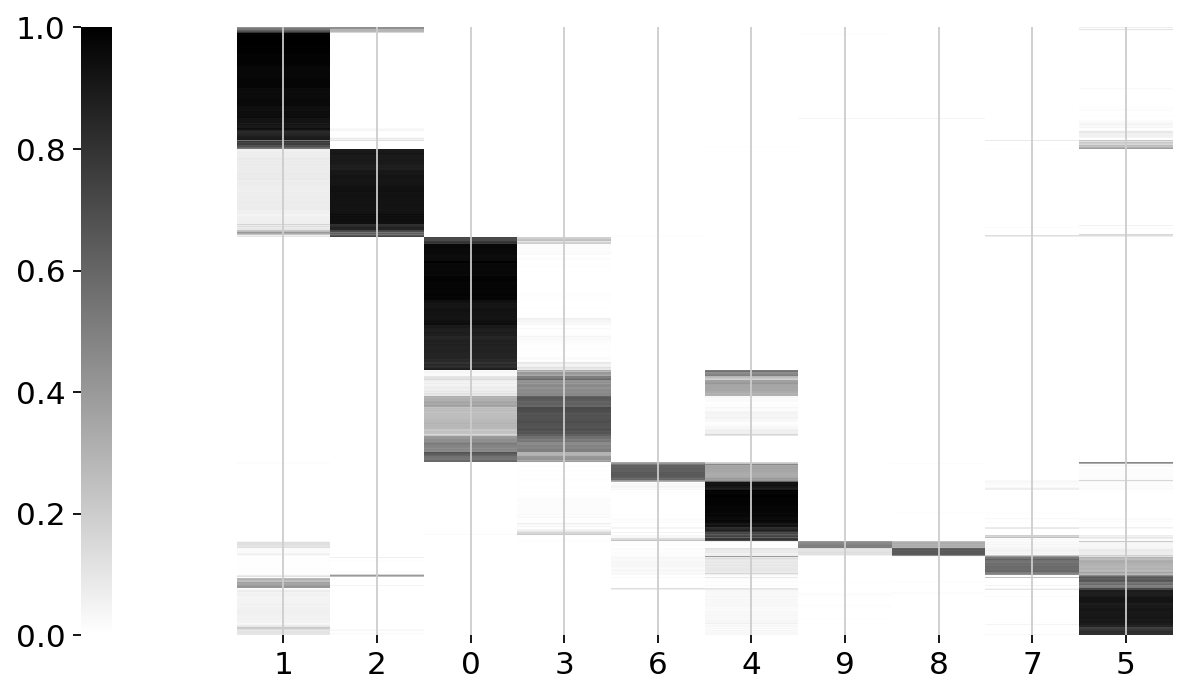

In [10]:
# Plot soft membership matrix heatmap visualization
es.pl.smm_heatmap(adata)

'X_umap'
No umap found - running umap...


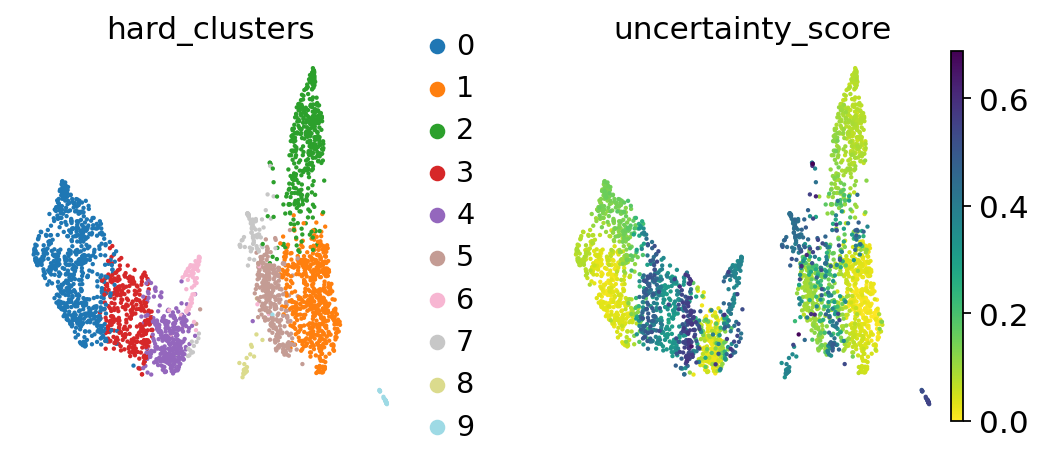

In [11]:
# Plot UMAP layout with points colored by
# ESCHR hard cluster labels and by uncertainty scores
es.pl.umap_heatmap(adata)

## Scanpy visualizations

In [12]:
# You can also use Scanpy to prepare a umap layout
# (or swap in your favorite 2D layout)
# to visualize the clustering results
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.umap(adata)

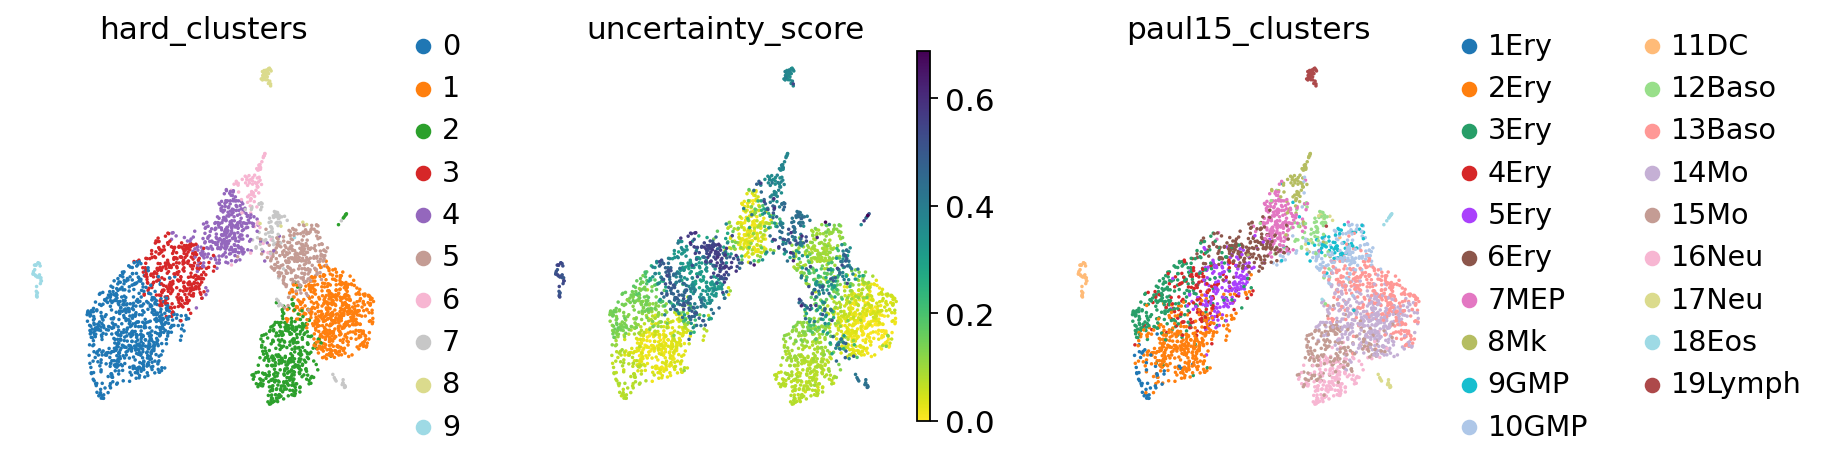

In [13]:
sc.pl.umap(adata, color=['hard_clusters', 'uncertainty_score', 'paul15_clusters'],show=True, color_map='viridis_r', s=10)

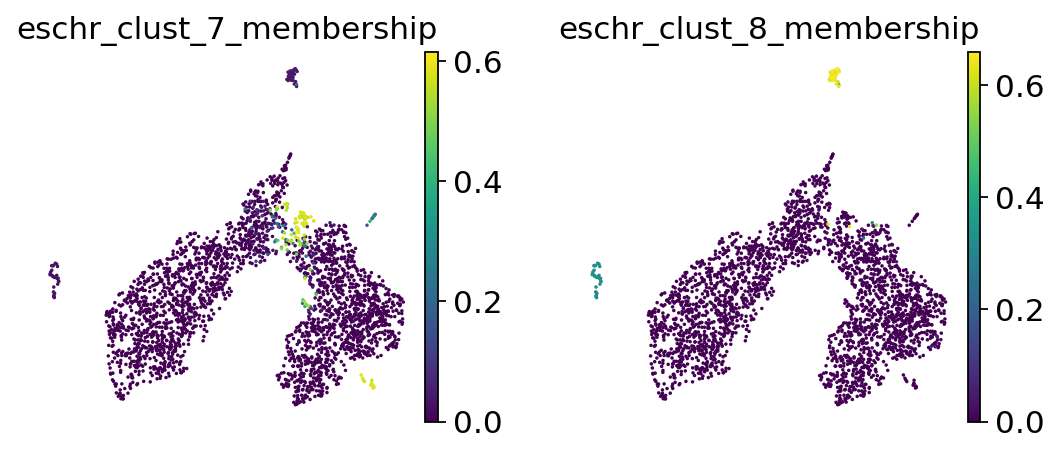

In [14]:
adata.obs['eschr_clust_7_membership'] = adata.obsm['soft_membership_matrix'][:,7]
adata.obs['eschr_clust_8_membership'] = adata.obsm['soft_membership_matrix'][:,8]
sc.pl.umap(adata, color=['eschr_clust_7_membership', 'eschr_clust_8_membership'],show=True, s=10)

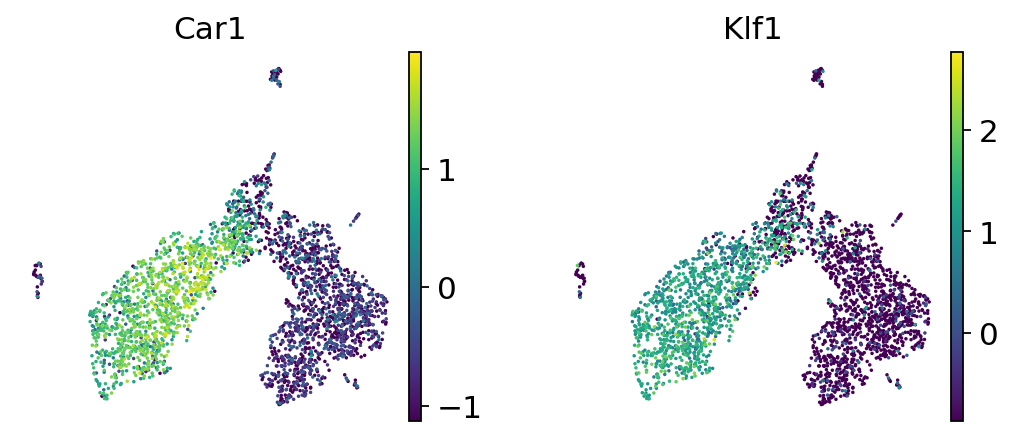

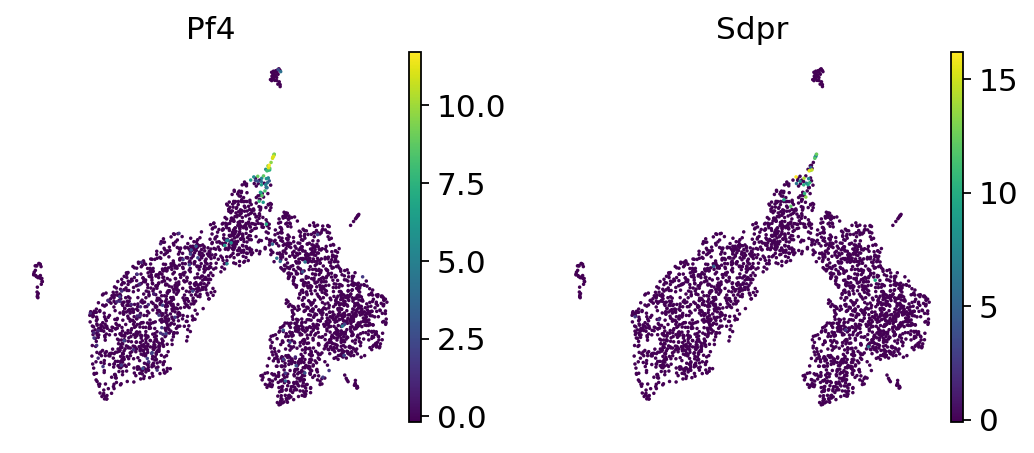

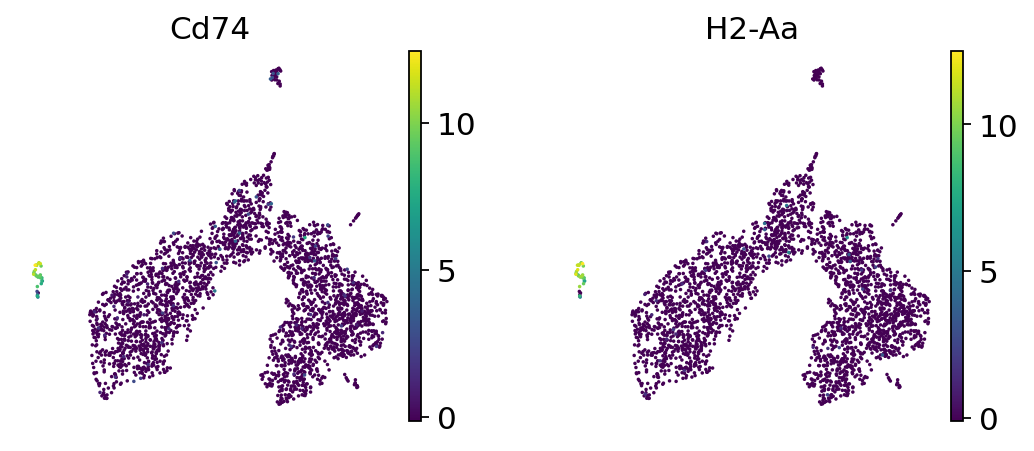

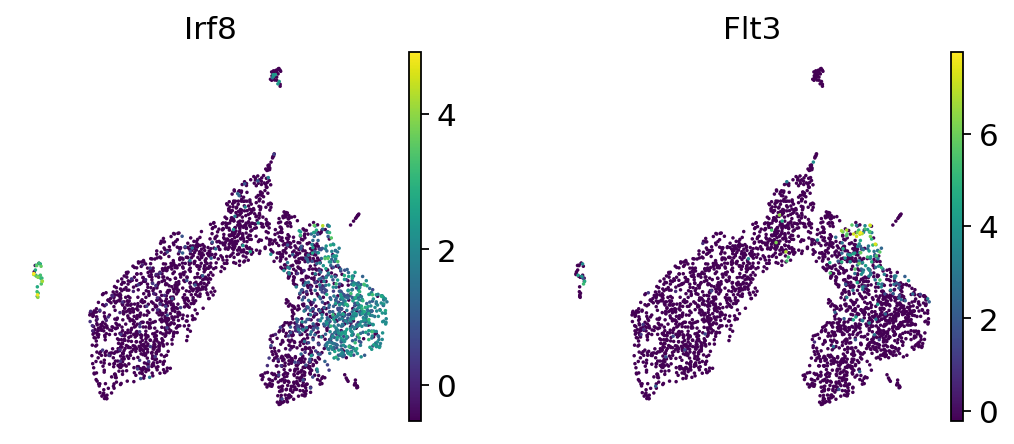

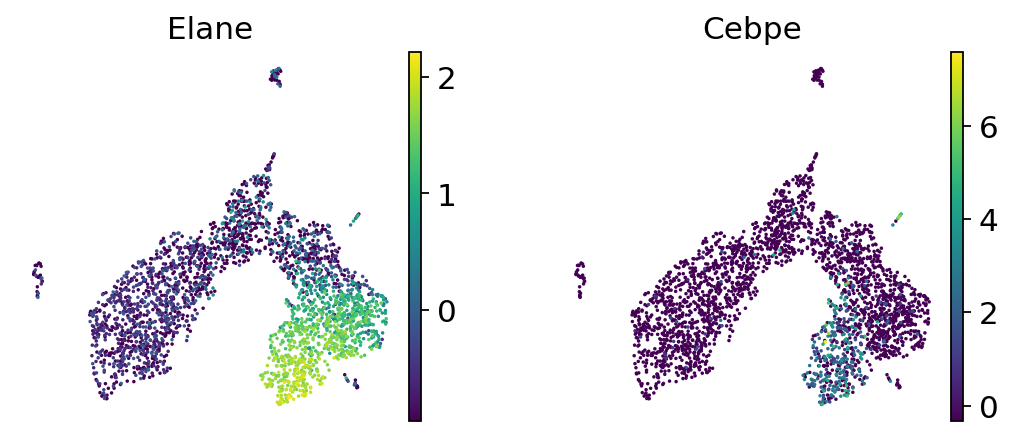

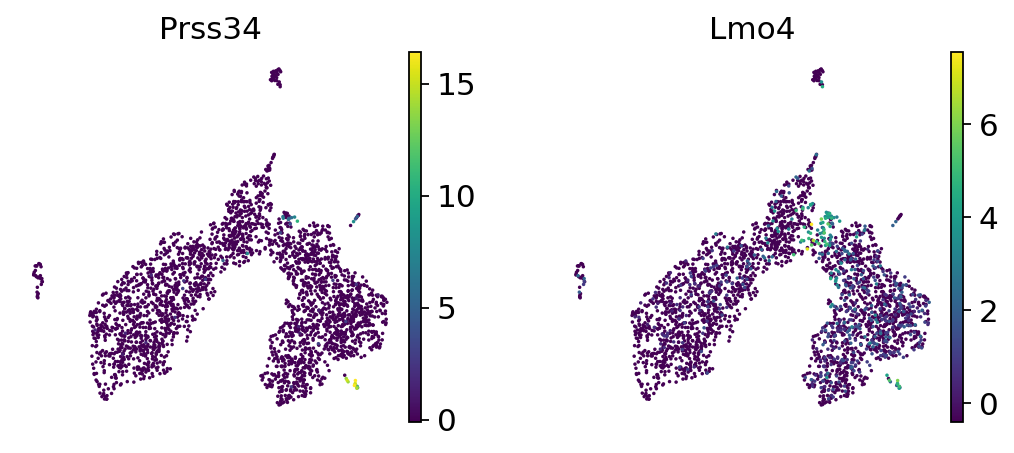

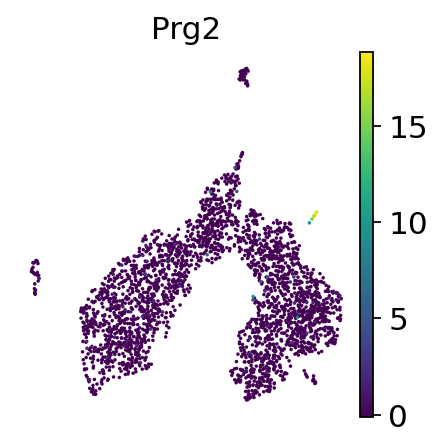

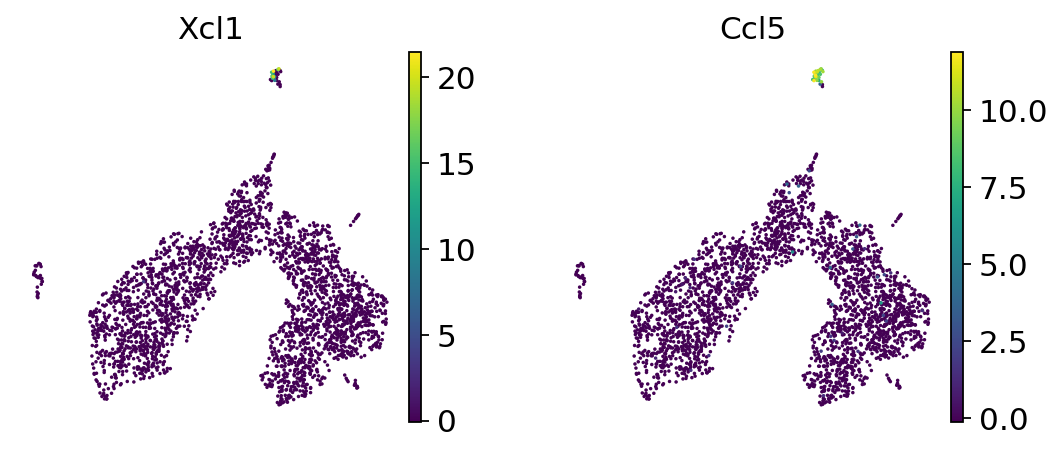

In [15]:
cell_type_markers = {"Erythroid": ['Car1', 'Klf1'],
                     "Megakaryocytes": ['Pf4','Sdpr'],
                     "Dendritic cells": ['Cd74','H2-Aa'],
                    "Monocytes":['Irf8', 'Flt3'],
                    "Neutrophils":['Elane','Cebpe'],
                    "Basophils": ['Prss34','Lmo4'],
                    "Eosonophils": ['Prg2'],
                    "Natural killer cells":['Xcl1','Ccl5']}
for markers_ls in cell_type_markers.values():
  sc.pl.umap(adata, color=markers_ls,show=True,s=10)

## Downstream scverse analyses with ESCHR clusters

ESCHR clusters can be used for external downstream analyses such as PAGA

In [16]:
sc.tl.paga(adata, groups='hard_clusters')

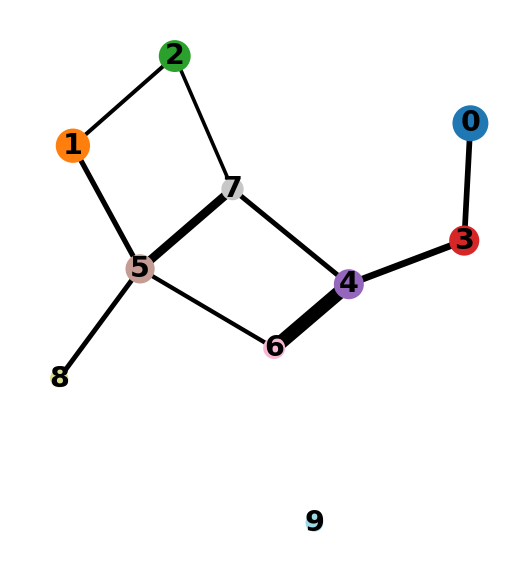

In [17]:
plt.rcParams["figure.figsize"] = [4,4]
sc.pl.paga(adata, color=['hard_clusters'], threshold=0.2)